In [1]:
import yfinance as yf
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Download historical BTC-USD data
btc = yf.download("BTC-USD", start="2015-01-01", end="2025-01-01", interval="1d")

# Optional: Reset index if you want 'Date' as a column
btc.reset_index(inplace=True)

# Flatten the multi-index columns
btc.columns = btc.columns.droplevel(1)

YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed


In [3]:
btc

Price,Date,Close,High,Low,Open,Volume
0,2015-01-01,314.248993,320.434998,314.002991,320.434998,8036550
1,2015-01-02,315.032013,315.838989,313.565002,314.079010,7860650
2,2015-01-03,281.082001,315.149994,281.082001,314.846008,33054400
3,2015-01-04,264.195007,287.230011,257.612000,281.145996,55629100
4,2015-01-05,274.473999,278.341003,265.084015,265.084015,43962800
...,...,...,...,...,...,...
3648,2024-12-27,94164.859375,97294.843750,93310.742188,95704.976562,52419934565
3649,2024-12-28,95163.929688,95525.898438,94014.289062,94160.187500,24107436185
3650,2024-12-29,93530.226562,95174.875000,92881.789062,95174.054688,29635885267
3651,2024-12-30,92643.210938,94903.320312,91317.132812,93527.195312,56188003691


# Returns

## simple returns
$$R_t = \frac{p_t - p_{t-1}}{p_{t-1}}$$

## log-returns
$$R_t = \ln\left(\frac{p_t}{p_{t-1}}\right) = \ln(p_t) - \ln(p_{t-1})$$


In [4]:
btc['simple-return'] = btc['Close'].pct_change()

In [5]:
btc['simple-return']

0            NaN
1       0.002492
2      -0.107767
3      -0.060079
4       0.038907
          ...   
3648   -0.017022
3649    0.010610
3650   -0.017167
3651   -0.009484
3652    0.008484
Name: simple-return, Length: 3653, dtype: float64

In [6]:
btc['log-return'] = np.log(btc['Close']).diff()

In [7]:
btc['log-return']

0            NaN
1       0.002489
2      -0.114028
3      -0.061959
4       0.038169
          ...   
3648   -0.017169
3649    0.010554
3650   -0.017316
3651   -0.009529
3652    0.008448
Name: log-return, Length: 3653, dtype: float64

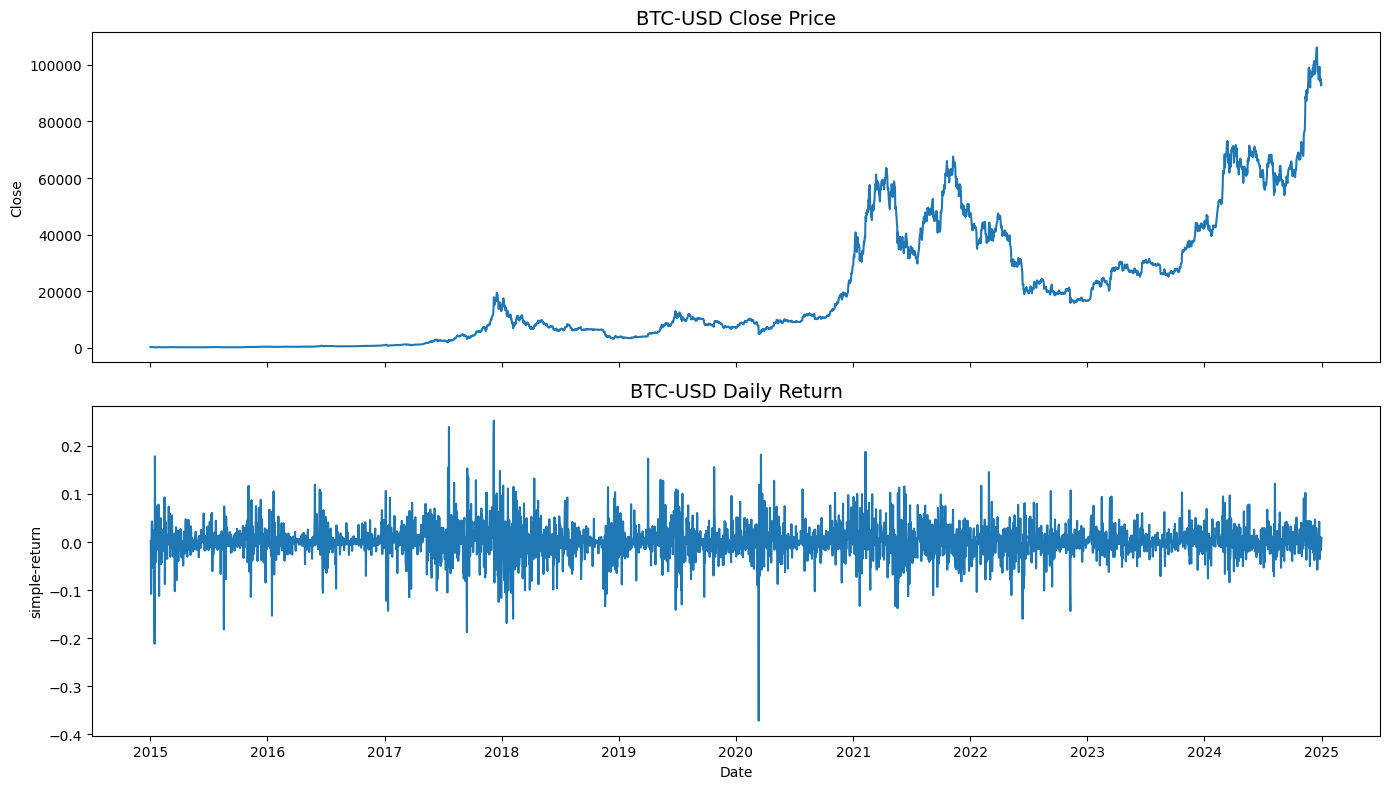

In [8]:
# Plotting
fig, ax = plt.subplots(2, 1, figsize=(14, 8), sharex=True)

# Plot Close Price
sns.lineplot(data=btc, x="Date", y="Close", ax=ax[0])
ax[0].set_title("BTC-USD Close Price", fontsize=14)

# Plot Return
sns.lineplot(data=btc, x="Date", y="simple-return", ax=ax[1])
ax[1].set_title("BTC-USD Daily Return", fontsize=14)

plt.tight_layout()
plt.show()

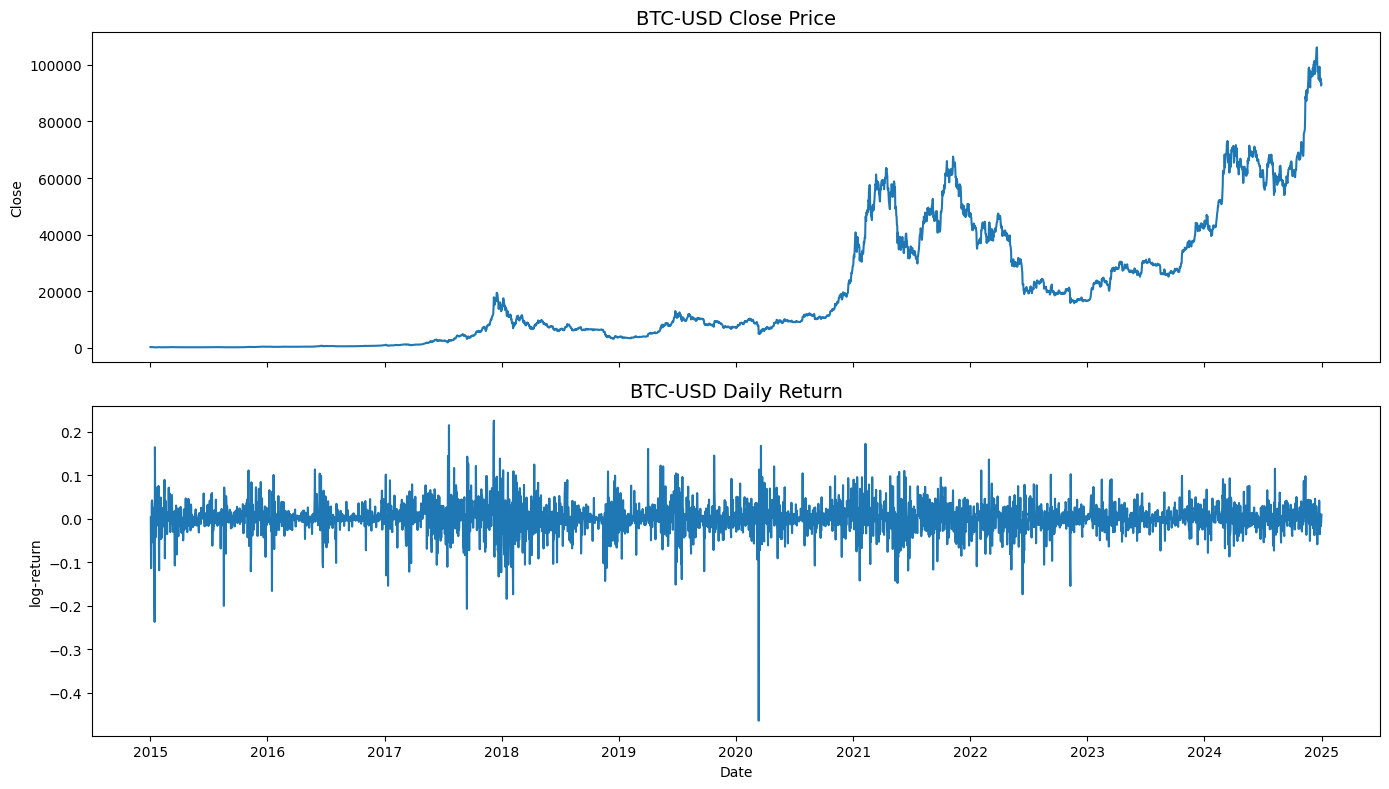

In [9]:
# Plotting
fig, ax = plt.subplots(2, 1, figsize=(14, 8), sharex=True)

# Plot Close Price
sns.lineplot(data=btc, x="Date", y="Close", ax=ax[0])
ax[0].set_title("BTC-USD Close Price", fontsize=14)

# Plot Return
sns.lineplot(data=btc, x="Date", y="log-return", ax=ax[1])
ax[1].set_title("BTC-USD Daily Return", fontsize=14)

plt.tight_layout()
plt.show()

In [10]:
# Parameters
initial_capital = 100_000
floor_percentage = 0.80  # floor = 80% of initial capital

risk_free_rate_annual = 0.05  # 2% annual risk-free rate
days = 365 * 2  # 2 years
rebalance_frequency = 30  # rebalance every 30 days

In [11]:
btc_ret = btc['log-return'].dropna()

In [12]:
# Parllel Worlds with Bootstrapping
m = 100000 # number of paths
rearrange_return = np.random.choice(btc_ret, size= (m, len(btc_ret)), replace=True)
btc_portfolios = np.exp(np.cumsum(rearrange_return, axis=1))

In [13]:
risk_free_daily_rate = (1 + risk_free_rate_annual) ** (1/365) - 1

In [14]:
multiplier = 2

In [15]:
# Initialize CPPI tracking
cppi_values = []
risky_weights = []

portfolio_value = initial_capital
floor_value = initial_capital * floor_percentage

for t in range(days):
    if t % rebalance_frequency == 0 or t == 0:
        cushion = portfolio_value - floor_value
        risky_allocation = np.where(multiplier * cushion > 0, multiplier * cushion, 0)
        risky_weight = np.where(risky_allocation / portfolio_value > 0,risky_allocation / portfolio_value, 1)
        safe_weight = 1 - risky_weight

    # Compute portfolio return
    risky_ret = (btc_portfolios[t] / btc_portfolios[t - 1] - 1) if t > 0 else 0
    safe_ret = risk_free_daily_rate

    portfolio_return = risky_weight * risky_ret + safe_weight * safe_ret
    portfolio_value *= (1 + portfolio_return)

    cppi_values.append(portfolio_value)
    risky_weights.append(risky_weight)
